In [84]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import japanize_matplotlib
from os.path import join
from settings import geodatadir
import itertools
from shapely.geometry import Point, LineString, MultiLineString
# 地図は背景に地理院地図（国土地理院）を使用している場合があります。

In [5]:
mesh_codes = list(itertools.chain.from_iterable(
    [(np.array([5238, 5239, 5240]) + xx) for xx in [0, 100, 200, 300]]))

In [6]:
mesh = gpd.read_file('data/syutoken_mesh.geojson')

In [98]:
kokusei = pd.concat([pd.read_csv(join(geodatadir, f"kokutyou500/tblT000847H{x}.txt"), encoding='sjis', skiprows=[1]) for x in mesh_codes])
kokusei = kokusei[['KEY_CODE', 'T000847001']]
kokusei.columns = ['KEY_CODE', 'people']
kokusei.KEY_CODE = kokusei.KEY_CODE.astype(str)
kokusei = pd.merge(mesh, kokusei, on='KEY_CODE')
kokusei['area_t'] = kokusei.area

In [80]:
keizai = pd.concat([pd.read_csv(join(geodatadir, f"keizai500/tblT000389H{x}.txt"), encoding='sjis', skiprows=1) for x in mesh_codes])
keizai.columns = ['KEY_CODE', 'company', 'people']
keizai.KEY_CODE = keizai.KEY_CODE.astype(str)
keizai = pd.merge(mesh, keizai, on='KEY_CODE')

In [285]:
stations = gpd.read_file(join(geodatadir, 'stations.geojson'), crs=4612).to_crs(2451)
syochiki = gpd.read_file(join(geodatadir, '../kokusei2020/syochiki/kanto.geojson'), crs=4612).to_crs(2451)

<AxesSubplot:>

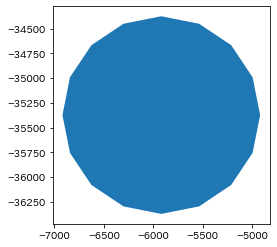

In [19]:
gpd.GeoSeries(
    stations[stations.N02_005 == '東京'].geometry.centroid.buffer(1000, resolution=4).values[0]
).plot()

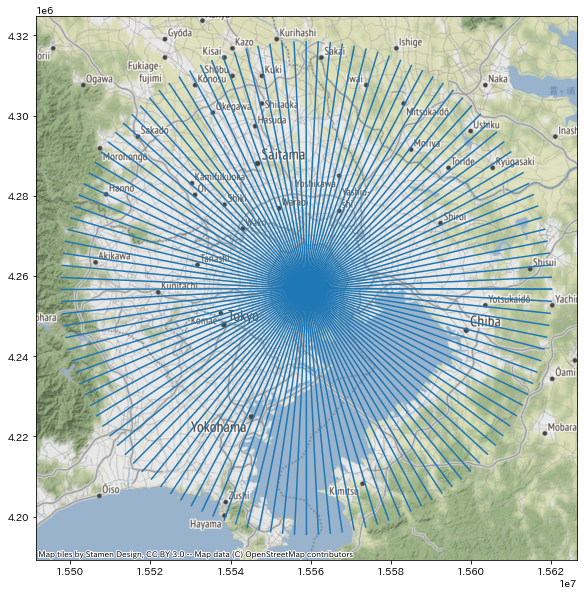

In [82]:
tokyoeki_p = stations[stations.N02_005 == '東京'].geometry.centroid
ans = [[[tokyoeki_p.x.values[0], tokyoeki_p.y.values[0]]] for x in range(129)]
for x in range(1, 500):
    x = tokyoeki_p.buffer(x * 100, resolution=32).values[0].exterior.coords.xy
    for i, (x, y) in enumerate(zip(x[0], x[1])):
        ans[i].append([x, y])
railways = gpd.GeoDataFrame({'railno' : [x + 1 for x in range(129)]},
    geometry=[LineString(x) for x in ans], crs=2451)
railways['railno'] = railways.index
cx.add_basemap(railways.to_crs(3857).plot(figsize=(10,10)))

In [70]:
len(tokyoeki_p.buffer(10 * 1000, resolution=32).values[0].exterior.coords.xy[0])

129

In [83]:
railways

,railno,geometry
0,0,"LINESTRING (-5918.423 -35374.207, -5818.423 -3..."
1,1,"LINESTRING (-5918.423 -35374.207, -5818.543 -3..."
2,2,"LINESTRING (-5918.423 -35374.207, -5818.905 -3..."
3,3,"LINESTRING (-5918.423 -35374.207, -5819.505 -3..."
4,4,"LINESTRING (-5918.423 -35374.207, -5820.345 -3..."
...,...,...
124,124,"LINESTRING (-5918.423 -35374.207, -5820.345 -3..."
125,125,"LINESTRING (-5918.423 -35374.207, -5819.505 -3..."
126,126,"LINESTRING (-5918.423 -35374.207, -5818.905 -3..."
127,127,"LINESTRING (-5918.423 -35374.207, -5818.543 -3..."


In [114]:
railwaysB = railways.copy()
railwaysB.geometry = railwaysB.geometry.buffer(1000)
x = gpd.overlay(kokusei, railwaysB)
x['ans'] = (x.people * (x.area / x.area_t)).astype(int)
x = x.groupby('railno').sum().reset_index()[['railno', 'ans']]
railway_ans = pd.merge(railways, x, on='railno')
railway_ans

,railno,geometry,ans
0,0,"LINESTRING (-5918.423 -35374.207, -5818.423 -3...",751254
1,1,"LINESTRING (-5918.423 -35374.207, -5818.543 -3...",710937
2,2,"LINESTRING (-5918.423 -35374.207, -5818.905 -3...",693649
3,3,"LINESTRING (-5918.423 -35374.207, -5819.505 -3...",716782
4,4,"LINESTRING (-5918.423 -35374.207, -5820.345 -3...",697284
...,...,...,...
124,124,"LINESTRING (-5918.423 -35374.207, -5820.345 -3...",851173
125,125,"LINESTRING (-5918.423 -35374.207, -5819.505 -3...",928875
126,126,"LINESTRING (-5918.423 -35374.207, -5818.905 -3...",906444
127,127,"LINESTRING (-5918.423 -35374.207, -5818.543 -3...",828960


In [117]:
railway_ans.to_file('data/railway_ans.geojson', driver='GeoJSON')

In [100]:
railway_points = []
for i, geom in zip(railways.railno, railways.geometry):
    for x, y, in zip(geom.coords.xy[0], geom.coords.xy[1]):
        railway_points.append([i, Point(x, y)])
railway_points= pd.DataFrame(railway_points)
railway_points = gpd.GeoDataFrame(railway_points, geometry=1, crs=2451)
railway_points['idx'] = railway_points.index
railway_points.columns = ['railno', 'geometry', 'idx']
railway_points

,railno,geometry,idx
0,0,POINT (-5918.423 -35374.207),0
1,0,POINT (-5818.423 -35374.207),1
2,0,POINT (-5718.423 -35374.207),2
3,0,POINT (-5618.423 -35374.207),3
4,0,POINT (-5518.423 -35374.207),4
...,...,...,...
64495,128,POINT (43581.577 -35374.207),64495
64496,128,POINT (43681.577 -35374.207),64496
64497,128,POINT (43781.577 -35374.207),64497
64498,128,POINT (43881.577 -35374.207),64498


In [110]:
railway_points_buf = railway_points.copy()
railway_points_buf.geometry = railway_points_buf.geometry.buffer(1000)
x = gpd.overlay(kokusei, railway_points_buf)
x['ans'] = (x.people * (x.area / x.area_t)).astype(int)
x = x.groupby('idx').sum().reset_index()[['idx', 'ans']]
railway_points_ans = pd.merge(railway_points, x, on='idx')
railway_points_ans

,railno,geometry,idx,ans
0,0,POINT (-5918.423 -35374.207),0,7521
1,0,POINT (-5818.423 -35374.207),1,9377
2,0,POINT (-5718.423 -35374.207),2,11297
3,0,POINT (-5618.423 -35374.207),3,14024
4,0,POINT (-5518.423 -35374.207),4,17258
...,...,...,...,...
56836,128,POINT (43581.577 -35374.207),64495,6509
56837,128,POINT (43681.577 -35374.207),64496,6426
56838,128,POINT (43781.577 -35374.207),64497,6312
56839,128,POINT (43881.577 -35374.207),64498,6193


In [111]:
railway_points_ans.to_csv('data/railway_points_ans.csv', index=None)

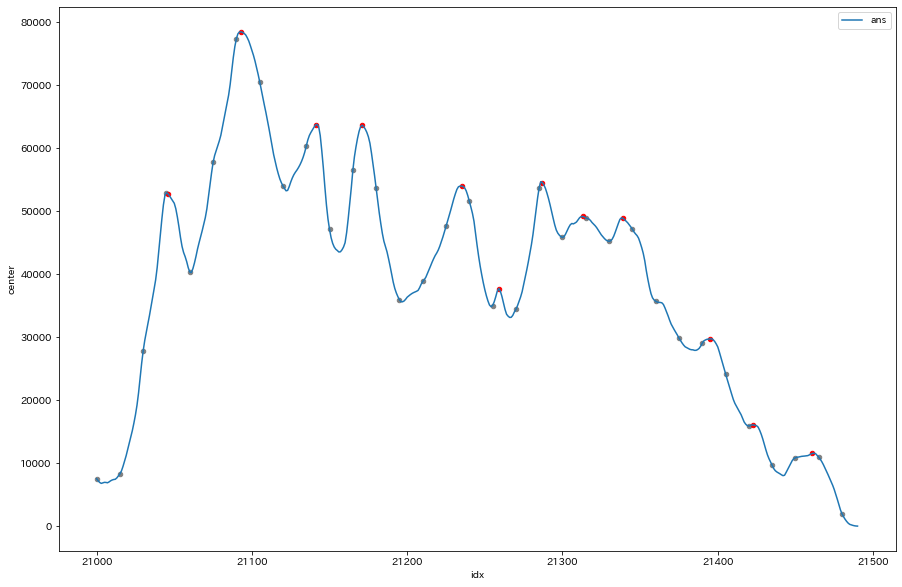

In [179]:
def station_decide(x):
    res = []
    for i, item in enumerate(x):
        try:
            if item > x[i+1] and item > x[i-1]:
                res.append(True)
            else:
                res.append(False)
        except IndexError:
            res.append(False)
            continue
    return res

rail42 = railway_points_ans[railway_points_ans.railno == 42].copy()
x = station_decide(rail42.ans.rolling(5, center=True).mean().values)
rail42['center'] = rail42.ans.where(x)
rail42['kouho'] = rail42.ans[::15]
rail42.to_csv('data/rail42.csv', index=None)
_, ax = plt.subplots()
rail42.plot(ax=ax, kind='line', x='idx', y='ans', figsize=(15, 10))
rail42.plot(ax=ax, kind='scatter', x='idx', y='kouho', figsize=(15, 10), color='gray')
rail42.plot(ax=ax, kind='scatter', x='idx', y='center', figsize=(15, 10), color='red')
plt.show()

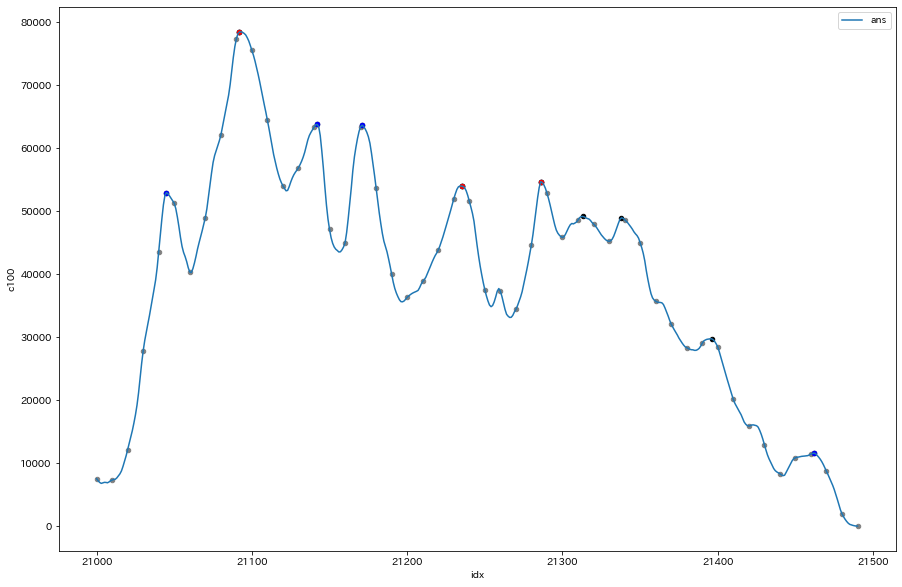

In [237]:
rail42_2 = railway_points_ans[railway_points_ans.railno == 42].copy()
rail42_2['s'] = rail42_2.ans[::10]
_, ax = plt.subplots()
rail42_2.plot(ax=ax, kind='line', x='idx', y='ans', figsize=(15, 10))
rail42_2.plot(ax=ax, kind='scatter', x='idx', y='s', figsize=(15, 10), color='gray')
for n, c in zip([100, 75, 50, 25][::-1], ['red', 'green', 'blue', 'black'][::-1]):
    x = rail42.ans >= rail42.ans.rolling(n, center=True).max()
    rail42_2[f'c{n}'] = rail42_2.ans.where(x)
    rail42_2.plot(ax=ax, kind='scatter', x='idx', y=f'c{n}', figsize=(15, 10), color=c)
plt.show()

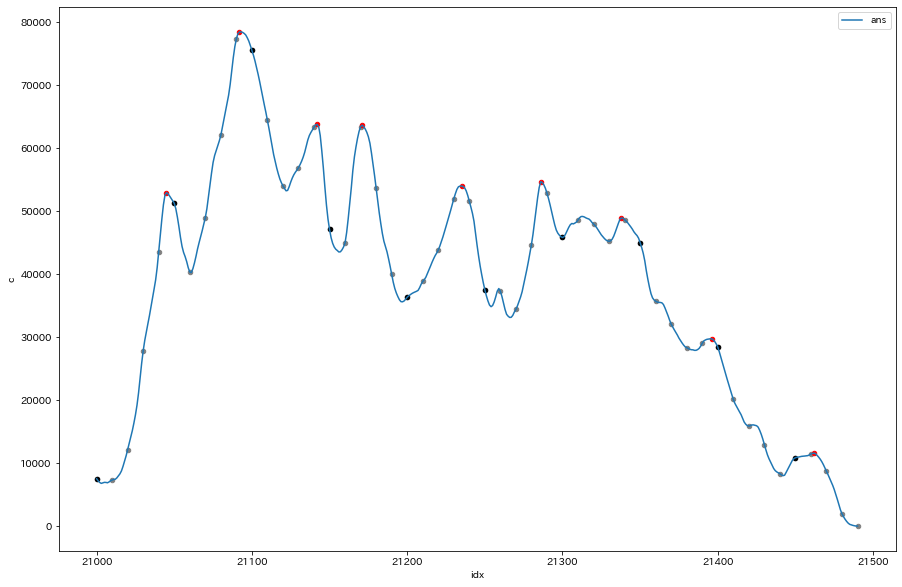

In [267]:
rail_t = railway_points_ans[railway_points_ans.railno == 42].copy()
rail_t['s'] = rail_t.ans[::10]
rail_t['s2'] = rail_t.ans[::50]
x = rail_t.ans >= rail_t.ans.rolling(40, center=True).max()
rail_t['c'] = rail_t.ans.where(x)

_, ax = plt.subplots()
rail_t.plot(ax=ax, kind='line', x='idx', y='ans', figsize=(15, 10))
rail_t.plot(ax=ax, kind='scatter', x='idx', y='s', figsize=(15, 10), color='gray')
rail_t.plot(ax=ax, kind='scatter', x='idx', y='s2', figsize=(15, 10), color='black')
rail_t.plot(ax=ax, kind='scatter', x='idx', y=f'c', figsize=(15, 10), color='red')
plt.show()

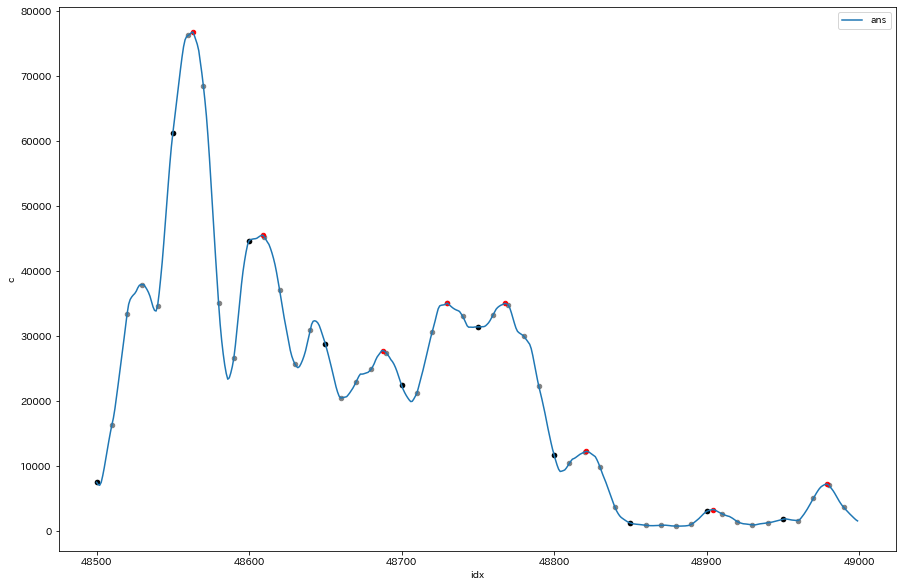

In [300]:
x = railway_points_ans[railway_points_ans.railno == 97].copy()
x['s'] = x.ans[::10]
x['s2'] = x.ans[::50]
xx = x.ans >= x.ans.rolling(40, center=True).max()
x['c'] = x.ans.where(xx)

_, ax = plt.subplots()
x.plot(ax=ax, kind='line', x='idx', y='ans', figsize=(15, 10))
x.plot(ax=ax, kind='scatter', x='idx', y='s', figsize=(15, 10), color='gray')
x.plot(ax=ax, kind='scatter', x='idx', y='s2', figsize=(15, 10), color='black')
x.plot(ax=ax, kind='scatter', x='idx', y=f'c', figsize=(15, 10), color='red')
plt.show()

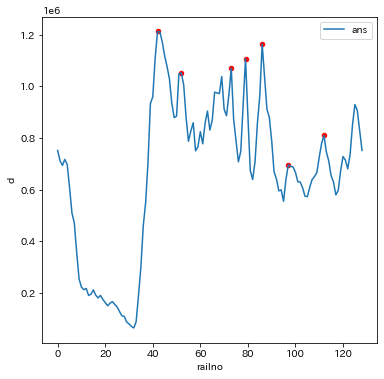

In [275]:
_, ax = plt.subplots(figsize=(6, 6))
x = railway_ans.ans >= railway_ans.ans.rolling(10, center=True).max()
railway_ans['d'] = railway_ans.ans.where(x)
railway_ans.plot(ax=ax, kind='line', x='railno', y='ans')
railway_ans.plot(ax=ax, kind='scatter', x='railno', y='d', color='red')
plt.show()

In [ ]:
railway_ans[~pd.isnull(railway_ans.d)].to_file('data/create-line-line.geojson', driver='GeoJSON')

<AxesSubplot:>

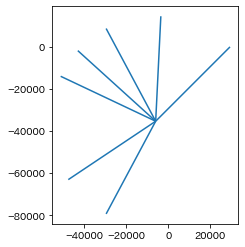

In [283]:
railway_ans[~pd.isnull(railway_ans.d)].plot()

In [281]:
create_line = pd.DataFrame()
for n in railway_ans[~pd.isnull(railway_ans.d)].railno:
    x = railway_points_ans[railway_points_ans.railno == n].copy()
    x['s'] = x.ans[::10]
    x['s2'] = x.ans[::50]
    xx = x.ans >= x.ans.rolling(40, center=True).max()
    x['c'] = x.ans.where(xx)
    create_line = pd.concat([create_line, x])
create_line

In [312]:
kasou_line_names_1 = pd.DataFrame(dict(
    railno=[42, 52, 73, 79, 86, 97, 112],
    railname='新東海道線、新東横線、新池袋線、新東上線、新高崎線、新日光線、新常磐線'.split('、')
))

In [309]:
x = create_line.sjoin(syochiki[['KEY_CODE', 'S_NAME', 'geometry']], how="left")
x['s_name_2'] = x.S_NAME.replace('(一|二|三|四|五|六|七|八|九|十)丁目', '' , regex=True)
#x.to_csv('data/create-line-point-2.csv', index=None)
x = x.sort_values('c', ascending=False).drop('geometry', 1).dropna(subset=['s'])
xx = pd.DataFrame(dict(
    railno=[42, 52, 73, 79, 86, 97, 112],
    railname='新東海道線、新東横線、新池袋線、新東上線、新高崎線、新日光線、新常磐線'.split('、')
))
x = pd.merge(x, xx, on='railno').sort_values('ans', ascending=False)
pd.merge(syochiki, x, on='KEY_CODE').drop('geometry', 1).to_csv('data/kasou-rank-02.csv', index=None)
x

,railno,idx,ans,s,s2,c,index_right,KEY_CODE,S_NAME,s_name_2,railname
307,86,43070,80239,80239.0,NaN,NaN,25235.0,13116002004,巣鴨四丁目,巣鴨,新高崎線
308,86,43080,80035,80035.0,NaN,NaN,25394.0,13117022006,滝野川六丁目,滝野川,新高崎線
159,42,21090,77377,77377.0,NaN,NaN,24328.0,13109026002,豊町二丁目,豊町,新東海道線
107,97,48560,76239,76239.0,NaN,NaN,25467.0,13118007001,西日暮里一丁目,西日暮里,新日光線
160,42,21100,75502,75502.0,75502.0,NaN,24309.0,13109022004,二葉四丁目,二葉,新東海道線
...,...,...,...,...,...,...,...,...,...,...,...
138,97,48880,789,789.0,NaN,NaN,12957.0,112140770,倉常,倉常,新日光線
39,112,56390,741,741.0,NaN,NaN,2125.0,082170540,山王,山王,新常磐線
34,112,56340,229,229.0,NaN,NaN,20854.0,122220620,北新田,北新田,新常磐線
33,112,56330,218,218.0,NaN,NaN,20854.0,122220620,北新田,北新田,新常磐線


In [314]:
pd.merge(
    kasou_line_names_1,
    railway_ans[~pd.isnull(railway_ans.d)],
    on='railno'
).drop('geometry', 1).sort_values('ans', ascending=False)

,railno,railname,ans,d
0,42,新東海道線,1211929,1211929.0
4,86,新高崎線,1163414,1163414.0
3,79,新東上線,1107232,1107232.0
2,73,新池袋線,1070082,1070082.0
1,52,新東横線,1051506,1051506.0
6,112,新常磐線,809287,809287.0
5,97,新日光線,695800,695800.0
